In [9]:
#run this in conda cmd before jupyter: jupyter nbextension enable --py widgetsnbextension
import numpy as np
from pathlib import Path
import pathlib
from os import listdir
from os.path import isfile, join, exists
import json
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops, regionprops_table
from skimage import io
from skimage.transform import resize

import pylab

# %matplotlib inline 
%matplotlib widget 
from matplotlib import pyplot as plt
import ImageAnalysis
import Morphology
import cv2 
from skimage.exposure import histogram
from skimage.filters import apply_hysteresis_threshold

import pandas as pd

In [10]:
input_path = "C:\\RESEARCH\\Mitophagy_data\\New Input data\\"
images = [input_path + f for f in listdir(input_path) if isfile(join(input_path, f))]
print(images)
settings = {}

['C:\\RESEARCH\\Mitophagy_data\\New Input data\\N2CCCP+Baf_1C=1T=0.tif', 'C:\\RESEARCH\\Mitophagy_data\\New Input data\\N2CCCP+Baf_3C=0T=0.tif', 'C:\\RESEARCH\\Mitophagy_data\\New Input data\\N2CCCP+Baf_4C=1T=0.tif', 'C:\\RESEARCH\\Mitophagy_data\\New Input data\\N2Con_3C=0T=0.tif', 'C:\\RESEARCH\\Mitophagy_data\\New Input data\\N2Con_3C=1T=0.tif', 'C:\\RESEARCH\\Mitophagy_data\\New Input data\\N2Rapa+CCCP+Baf_1C=1T=5.tif', 'C:\\RESEARCH\\Mitophagy_data\\New Input data\\N3CCCP+Baf_1C=1T=0.tif', 'C:\\RESEARCH\\Mitophagy_data\\New Input data\\N3CCCP+Baf_2C=0T=0.tif', 'C:\\RESEARCH\\Mitophagy_data\\New Input data\\N3CCCP_1C=0T=0.tif', 'C:\\RESEARCH\\Mitophagy_data\\New Input data\\N3CCCP_2C=0T=0.tif', 'C:\\RESEARCH\\Mitophagy_data\\New Input data\\N3CCCP_4C=1T=0.tif', 'C:\\RESEARCH\\Mitophagy_data\\New Input data\\N3CCCP_4C=1T=9.tif', 'C:\\RESEARCH\\Mitophagy_data\\New Input data\\N3Con_1C=0T=0.tif', 'C:\\RESEARCH\\Mitophagy_data\\New Input data\\N3Con_1C=0T=1.tif', 'C:\\RESEARCH\\Mitopha

In [11]:
def hysteresisThresholdingStack(stack, low, high):
    return apply_hysteresis_threshold(stack, low*255, high*255)

def determineHysteresisThresholds(img, outputPath=None, bins=256, movingAverageFrame=20, cutOffSlope=4, highVal=0.95):
    counts, centers = histogram(img, nbins=bins)
    #remove 'black'
    counts = counts[1:]
    centers = centers[1:]

    # normalise
    # counts = counts/np.sum(counts)

    df = pd.DataFrame(counts)
    movingAverage = df.rolling(movingAverageFrame, center=True).mean()


    # first derivitive
    # gradient = []
    # gradient2 = []
    # for i in range(0,len(counts)-1):
    #     gradient.append(counts[i+1] - counts[i])
    
    # gradient.append(0)
    # df = pd.DataFrame(gradient)
    # movingAverage = df.rolling(movingAverageFrame, center=True).mean()


    #print(movingAverage)

    # calculate second derivitive
    # for i in range(0,len(movingAverage[0])-1):
    #     gradient2.append(movingAverage[0][i+1] - movingAverage[0][i])
    
    # gradient2.append(0)
    # plt.plot(centers[startIndex:], gradient[startIndex:], color='black')
    # plt.show()

    # df = pd.DataFrame(gradient2)
    # movingAverage = df.rolling(movingAverageFrame, center=True).mean()
    startIntensity = 10
    useIntensityLow = startIntensity
    useIntensityHigh = 0
    #for i in range(len(movingAverage[0])*3//4,startIntensity, -1):
    for i in range(len(movingAverage[0])*3//4,startIntensity, -1):
        # print(i,": ", movingAverage[0][i-10]/movingAverage[0][i+10] )
        #if movingAverage[0][i] <= mEdges:
        if movingAverage[0][i-10]/movingAverage[0][i+10] >= cutOffSlope:
              useIntensityLow = i
              print("Low intensity to be used: ", useIntensityLow/bins)
              print("High intensity to be used: ", (1.0-(1.0-useIntensityLow/bins)/2))
              #print("High intensity to be used: ", highVal)
              break  

    print(outputPath)

    return (useIntensityLow/bins, (1.0-(1.0-useIntensityLow/bins)/2))
    #return (useIntensityLow/bins, highVal)


In [12]:
def update(val):
    global z
    global low
    global high
    global stack
    global ax2
    global ax
    global centers
    global gradient
    global gradient2
    global startIndex
    global movingAverage
    global save
    global save_count
    global name
    global settings
    settings[name] = [low.val, high.val]
    thresholded = hysteresisThresholdingStack(stack, low.val, high.val).astype(int)*255
    #thresholded = binarizeStack(stack)
    stackRGB = np.stack((stack, stack, stack), axis=-1)
    thresholdedRGB = np.stack((thresholded, np.zeros_like(thresholded),np.zeros_like(thresholded)), axis=-1)
    finalStack = stackRGB *0.6 + thresholdedRGB *0.4
    ax2.imshow(finalStack[int(z.val),:,:]/255)
    print(save_count)
    ax.cla()
    ax.imshow(stack[int(z.val)])
    #ax.plot(centers[startIndex:], movingAverage[0][startIndex:], color='black')
    #ax.axvline(low.val, 0, 1, label='Low')
    #ax.axvline(high.val, 0, 1, label='High')


In [13]:
def saveParams():
    global save_count
    global name
    global low
    global high
    save_count += 1
    settings[name] = {"Low":low.val, "High":high.val}
    print("Save", save_count)

In [14]:
def chooseHysteresisParams(img, bins=256, remove_zero=False, remove_max=False):
    global z
    global low
    global high
    global stack
    global ax2
    global ax
    global centers
    global gradient
    global gradient2
    global startIndex
    global movingAverage
    global save
    global name
    global settings
    ax = None
    ax2 = None
    startIndex = 0
    if remove_zero:
        startIndex = 1
    
    stack = img
    
    counts, centers = histogram(img, nbins=bins)
    #remove 'black'
    counts = counts[1:]
    centers = centers[1:]

    df = pd.DataFrame(counts[startIndex:])
    movingAverage = df.rolling(20, center=True).mean()

    (lowInit, highInit) = determineHysteresisThresholds(img)
    
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    fig.tight_layout()
    ax = plt.subplot(121)
    plt.subplots_adjust(left=0.15, bottom=0.4)   
    
    axcolor = 'lightgoldenrodyellow'
    axLow = plt.axes([0.15, 0.15, 0.65, 0.03], facecolor=axcolor)
    axHigh = plt.axes([0.15, 0.2, 0.65, 0.03], facecolor=axcolor)
    axZ = plt.axes([0.15, 0.25, 0.65, 0.03], facecolor=axcolor)

    low = pylab.Slider(axLow, 'Low', 0.0, 1.0, valinit=lowInit)
    high = pylab.Slider(axHigh, 'High', 0.0, 1.0, valinit=highInit)
    z = pylab.Slider(axZ, 'z', 0, img.shape[0] - 1, valinit=int(stack.shape[0]/2), valstep = 1)
    #save = pylab.Button(axB, 'Save', color="yellow")
    #reset_button = pylab.Button(axR, 'Reset', color='red')
    #reset_button.on_clicked(reset)
    #save.on_clicked(saveParams)

    #ax.plot(centers[startIndex:], movingAverage[0][startIndex:], color='black')
    #ax.axvline(low.val, 0, 1, label='Low')
    #ax.axvline(high.val, 0, 1, label='High')
    settings[name] = [lowInit, highInit]
    print(settings)
    ax2 = plt.subplot(122)
    #plt.subplots_adjust(hspace = .001)
    thresholded = hysteresisThresholdingStack(stack, low.val, high.val).astype(int)*255
    #thresholded = binarizeStack(stack)
    stackRGB = np.stack((stack, stack, stack), axis=-1)
    thresholdedRGB = np.stack((thresholded, np.zeros_like(thresholded),np.zeros_like(thresholded)), axis=-1)
    finalStack = stackRGB *0.6 + thresholdedRGB *0.4
    ax.imshow(stack[int(z.val)])
    ax2.imshow(finalStack[int(z.val),:,:]/255)

    low.on_changed(update)
    high.on_changed(update)
    z.on_changed(update)

    plt.show()

In [15]:
save_count = 0
def reset(event):
    global low
    global high
    global z
    
    low.reset()
    high.reset()
    z.reset()

Number of samples: 20
N2CCCP+Baf_1C=1T=0.tif
Low intensity to be used:  0.125
High intensity to be used:  0.5625
None
{'N2CCCP+Baf_1C=1T=0.tif': [0.125, 0.5625]}


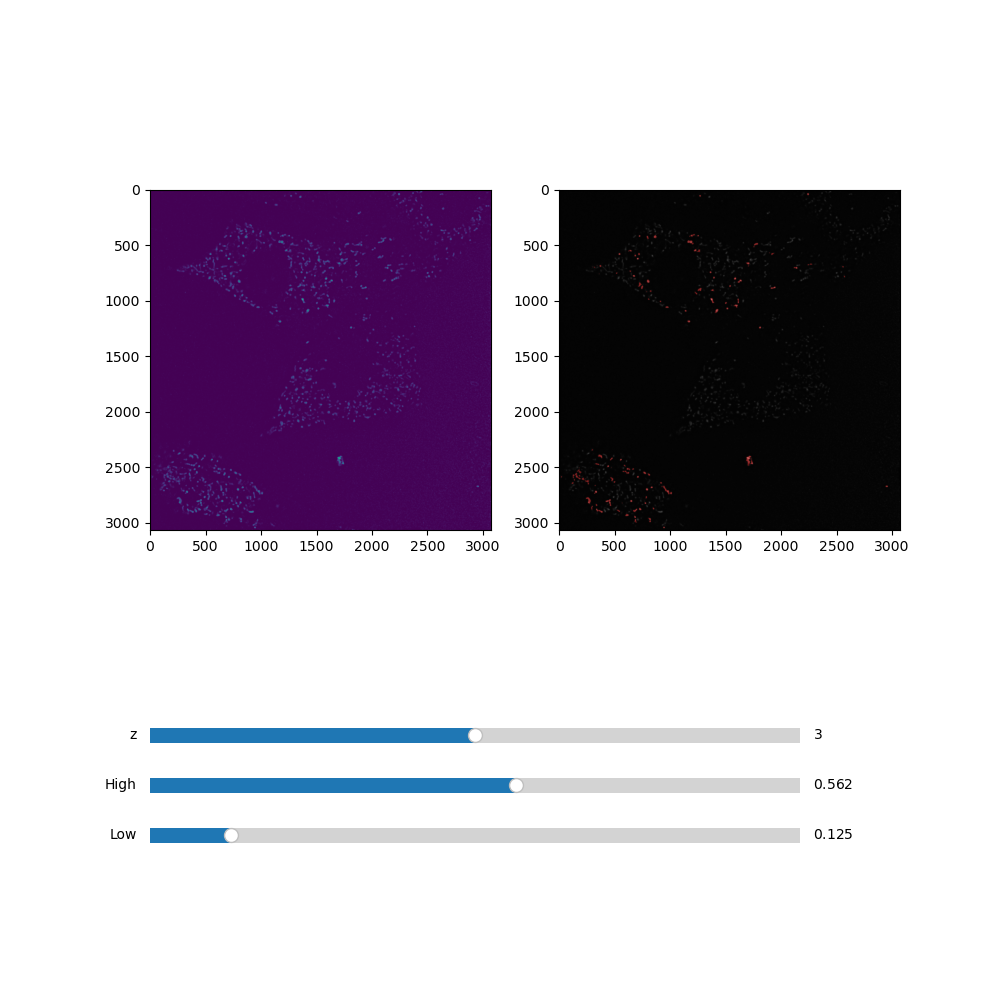

In [16]:
index = 0
print("Number of samples:", len(images))
image = io.imread(images[index])
print(images[index].split('\\')[-1])
name = images[index].split('\\')[-1]
chooseHysteresisParams(image)

In [17]:
global settings
print(settings)

{'N2CCCP+Baf_1C=1T=0.tif': [0.125, 0.5625]}
